In [1]:
# Data processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Model and performance evaluation
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import precision_recall_fscore_support as score 
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Hyperparameter tuning
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
# from hyperopt import tpe, STATUS_OK, Trials, hp, fmin, STATUS_OK, space_eval

#add explainable AI libraries
import shap
initjs = shap.initjs()
from sklearn.inspection import partial_dependence,PartialDependenceDisplay
import pycebox.ice as pice

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# import the data
data = pd.read_csv('/Users/danherman/Desktop/oud_treatment_outcome/data/clean_data/final12SEP23.csv')

In [3]:
data.shape

(1315, 3018)

In [4]:
# set the feature and target variable
X = data.drop(columns='outcome')
y = data.outcome

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [5]:
y.value_counts(normalize=True)

outcome
0.0    0.704183
1.0    0.295817
Name: proportion, dtype: float64

###  Before executing grid search alogrithms, a benchmark model has to be fitted

In [6]:
# Initiate XGBoost Classifier
xgbc0 = XGBClassifier()

# Print default setting
xgbc0.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [7]:
# Train the model
xgbc0 = XGBClassifier(seed=0).fit(X_train,y_train)

# Make prediction
xgbc0_predict = xgbc0.predict(X_test)

# Get predicted probability
xgbc0_predict_prob = xgbc0.predict_proba(X_test)[:,1]

In [8]:
# Get performance metrics
precision, recall, fscore, support = score(y_test, xgbc0_predict)

# Print result
print(f'The recall value for the baseline xgboost model is {recall[1]:.4f}')

The recall value for the baseline xgboost model is 0.3217


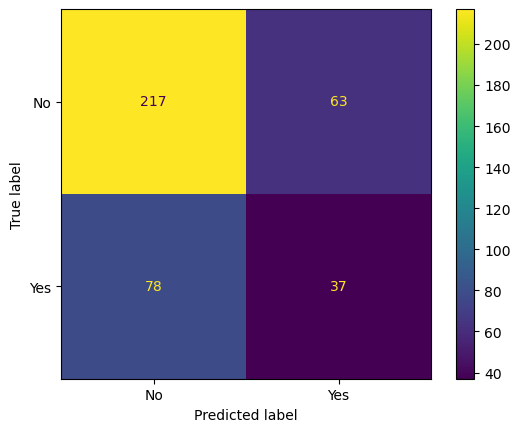

In [9]:
# show confusion matrix display
confusion_matrix = confusion_matrix(y_test, xgbc0_predict)
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=['No', 'Yes'])
disp.plot();

### We wil now take a brute force approach to grid search to find ideal params to optimize the model
We will keep the grid search space relatively small to finish in a reasonable timeframe 

In [10]:
# Define the search space
param_grid = { 
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [ 0.3, 0.5 , 0.8 ],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [0, 0.5, 1, 5],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [0, 0.5, 1, 5]
    }
# Set up score
scoring = ['recall']
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [11]:
# Define grid search
grid_search = GridSearchCV(estimator=xgbc0, 
                           param_grid=param_grid, 
                           scoring=scoring, 
                           refit='recall', 
                           n_jobs=8, 
                           cv=kfold, 
                           verbose=5)

# Fit grid search
grid_result = grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 1/3] END colsample_bytree=0.3, reg_alpha=0, reg_lambda=0; recall: (test=0.242) total time=   3.1s
[CV 2/3] END colsample_bytree=0.3, reg_alpha=0, reg_lambda=0; recall: (test=0.348) total time=   3.1s
[CV 1/3] END colsample_bytree=0.3, reg_alpha=0, reg_lambda=0.5; recall: (test=0.198) total time=   3.1s
[CV 3/3] END colsample_bytree=0.3, reg_alpha=0, reg_lambda=0; recall: (test=0.264) total time=   3.1s
[CV 3/3] END colsample_bytree=0.3, reg_alpha=0, reg_lambda=0.5; recall: (test=0.264) total time=   3.1s
[CV 2/3] END colsample_bytree=0.3, reg_alpha=0, reg_lambda=1; recall: (test=0.250) total time=   3.1s
[CV 2/3] END colsample_bytree=0.3, reg_alpha=0, reg_lambda=0.5; recall: (test=0.293) total time=   3.2s
[CV 1/3] END colsample_bytree=0.3, reg_alpha=0, reg_lambda=1; recall: (test=0.198) total time=   3.3s
[CV 2/3] END colsample_bytree=0.3, reg_alpha=0.5, reg_lambda=0; recall: (test=0.283) total time=   3.0s
[CV 1/3] END

In [12]:
# Print grid search summary
grid_result

# Print the best score and the corresponding hyperparameters
print(f'The best score is {grid_result.best_score_:.4f}')
print('The best score standard deviation is', round(grid_result.cv_results_['std_test_recall'][grid_result.best_index_], 4))
print(f'The best hyperparameters are {grid_result.best_params_}')

The best score is 0.3100
The best score standard deviation is 0.0477
The best hyperparameters are {'colsample_bytree': 0.5, 'reg_alpha': 0, 'reg_lambda': 0.5}


In [13]:
# Make prediction using the best model
grid_predict = grid_search.predict(X_test)

# Get predicted probabilities
grid_predict_prob = grid_search.predict_proba(X_test)[:,1]

# Get performance metrics
precision, recall, fscore, support = score(y_test, grid_predict)

# Print result
print(f'The recall value for the xgboost grid search is {recall[1]:.4f}')

The recall value for the xgboost grid search is 0.2783


### Random Search for XGBoost
In step 7, we are using a random search for XGBoost hyperparameter tuning. Since random search randomly picks a fixed number of hyperparameter combinations, we can afford to try more hyperparameters and more values. Therefore, we added three more parameters to the search space.

In [14]:
# Define the search space
param_grid = { 
    # Learning rate shrinks the weights to make the boosting process more conservative
    "learning_rate": [0.0001,0.001, 0.01, 0.1, 1] ,
    # Maximum depth of the tree, increasing it increases the model complexity.
    "max_depth": range(3,21,3),
    # Gamma specifies the minimum loss reduction required to make a split.
    "gamma": [i/10.0 for i in range(0,5)],
    # Percentage of columns to be randomly samples for each tree.
    "colsample_bytree": [i/10.0 for i in range(3,10)],
    # reg_alpha provides l1 regularization to the weight, higher values result in more conservative models
    "reg_alpha": [1e-5, 1e-2, 0.1, 1, 10, 100],
    # reg_lambda provides l2 regularization to the weight, higher values result in more conservative models
    "reg_lambda": [1e-5, 1e-2, 0.1, 1, 10, 100]}
# Set up score
scoring = ['recall']
# Set up the k-fold cross-validation
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

In [15]:
# Define random search
random_search = RandomizedSearchCV(estimator=xgbc0, 
                           param_distributions=param_grid, 
                           n_iter=48,
                           scoring=scoring, 
                           refit='recall', 
                           n_jobs=8, 
                           cv=kfold, 
                           verbose=5)
# Fit grid search
random_result = random_search.fit(X_train, y_train)




Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 2/3] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.0001, max_depth=3, reg_alpha=100, reg_lambda=1; recall: (test=0.000) total time=   2.7s
[CV 3/3] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.0001, max_depth=3, reg_alpha=100, reg_lambda=1; recall: (test=0.000) total time=   2.8s
[CV 1/3] END colsample_bytree=0.5, gamma=0.4, learning_rate=0.0001, max_depth=3, reg_alpha=100, reg_lambda=1; recall: (test=0.000) total time=   2.8s
[CV 2/3] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.001, max_depth=15, reg_alpha=10, reg_lambda=1; recall: (test=0.000) total time=   4.4s
[CV 1/3] END colsample_bytree=0.7, gamma=0.1, learning_rate=0.001, max_depth=15, reg_alpha=10, reg_lambda=1; recall: (test=0.000) total time=   5.5s
[CV 2/3] END colsample_bytree=0.8, gamma=0.2, learning_rate=0.0001, max_depth=9, reg_alpha=0.01, reg_lambda=100; recall: (test=0.087) total time=   5.5s
[CV 2/3] END colsample_bytree=0.5, ga

In [16]:
# Print grid search summary
random_result
# Print the best score and the corresponding hyperparameters
print(f'The best score is {random_result.best_score_:.4f}')
print('The best score standard deviation is', round(random_result.cv_results_['std_test_recall'][random_result.best_index_], 4))
print(f'The best hyperparameters are {random_result.best_params_}')

The best score is 0.3283
The best score standard deviation is 0.0397
The best hyperparameters are {'reg_lambda': 1e-05, 'reg_alpha': 0.01, 'max_depth': 18, 'learning_rate': 1, 'gamma': 0.1, 'colsample_bytree': 0.8}


In [17]:
# Make prediction using the best model
random_predict = random_search.predict(X_test)

# Get predicted probabilities
random_predict_prob = random_search.predict_proba(X_test)[:,1]

# Get performance metrics
precision, recall, fscore, support = score(y_test, random_predict)

# Print result
print(f'The recall value for the xgboost random search is {recall[1]:.4f}')

The recall value for the xgboost random search is 0.3217


In [19]:
# Initiate XGBoost Classifier
xgbc1 = XGBClassifier(
    colsample_bytree=0.8,
    gamma=0.1,
    learning_rate=1,
    max_depth=18,
    reg_alpha=0.01,
    reg_lambda=0.01,
    seed=0
).fit(X_train,y_train)

# Make prediction
xgbc1_predict = xgbc1.predict(X_test)

# Get predicted probability
xgbc1_predict_prob = xgbc1.predict_proba(X_test)[:,1]

# Get performance metrics
precision, recall, fscore, support = score(y_test, xgbc1_predict)

# Print result
print(f'The recall value for the xgboost optimization is {recall[1]:.4f}')

The recall value for the xgboost optimization is 0.2957


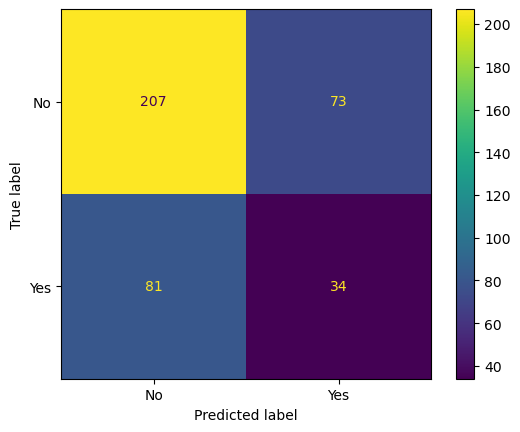

In [21]:
# show confusion matrix display (rebind new object)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, xgbc1_predict)


disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=['No', 'Yes'])

disp.plot();

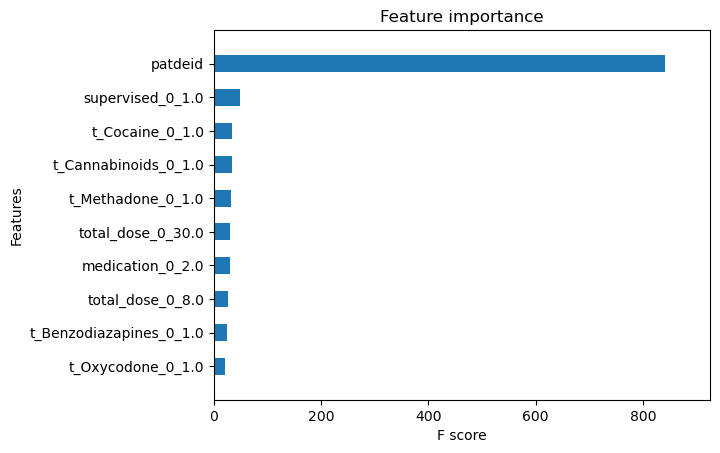

In [22]:
# plot feature importance from xboost
import xgboost
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(xgbc1, max_num_features=10, 
                     show_values=False,
                     height=0.5,
                     xlim=None,
                     ylim=None,
                     title='Feature importance',
                     xlabel='F score',
                     ylabel='Features',
                     grid=False);

In [23]:
explainer = shap.TreeExplainer(xgbc1)
shap_values = explainer.shap_values(X_test)

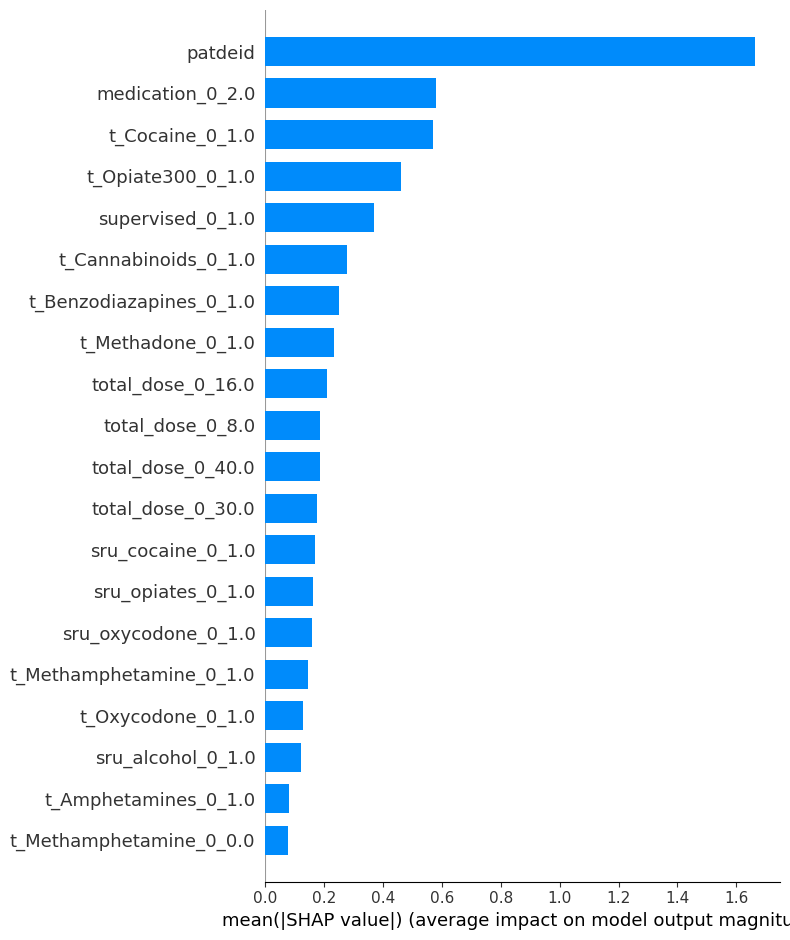

In [25]:
shap.summary_plot(shap_values, X_test, 
                  plot_type="bar",  
                  max_display=20,
                  )

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


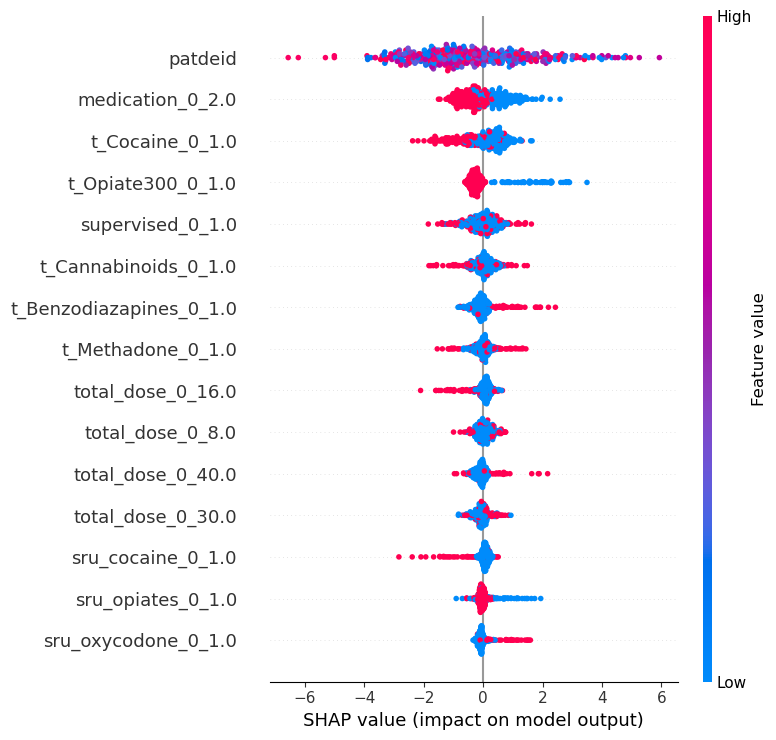

In [27]:
shap.summary_plot(shap_values, X_test, 
                  max_display=15,
                  );

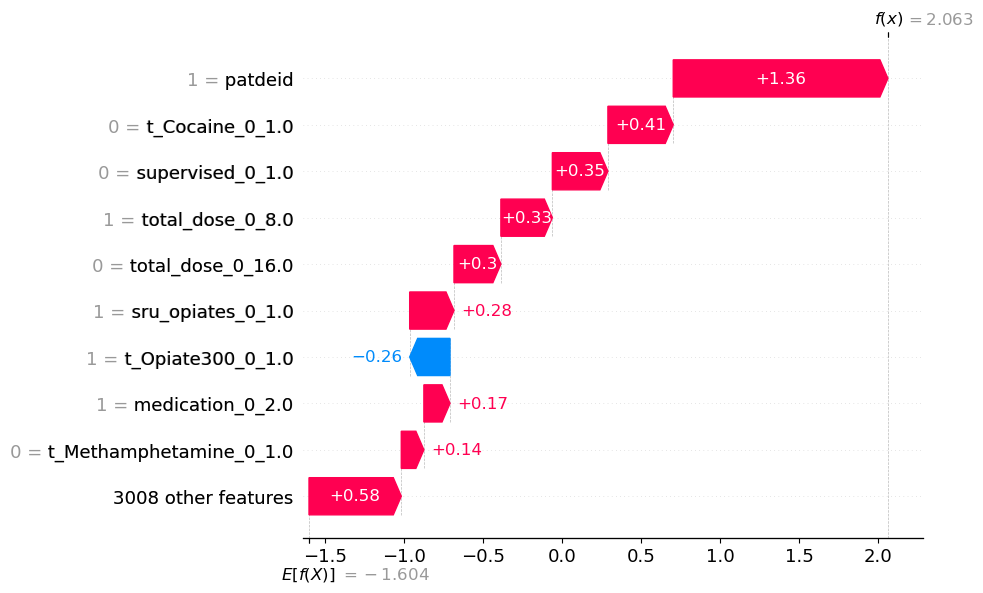

In [28]:
explainer = shap.Explainer(xgbc1)
shap_values = explainer(X)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

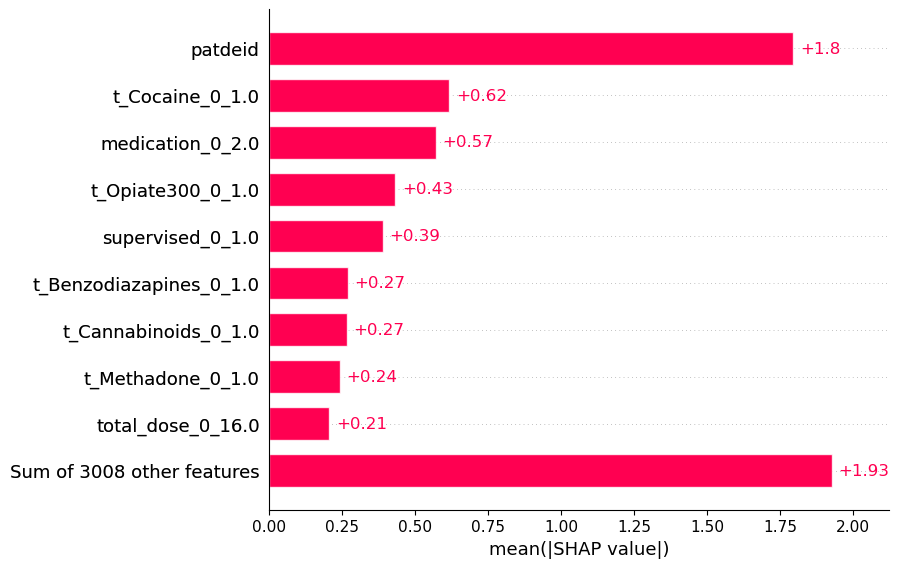

In [29]:
explainer = shap.Explainer(xgbc1)
shap_values = explainer(X)

shap.plots.bar(shap_values)

In [ ]:
# create partial dependence plot
features = ['t_Opiate300','t_Cocaine',('t_Opiate300','t_Cocaine')]
fig, ax = plt.subplots(figsize=(10,5))
PartialDependenceDisplay.from_estimator(xgbc1, X_train, features=features, ax=ax);


In [70]:
X_train[:5]

,sru_alcohol,sru_cannabis,sru_cocaine,sru_amphetamine,sru_methamphetamine,sru_opiates,sru_benzodiazepines,sru_propoxyphene,sru_methadone,sru_oxycodone,sru_other,t_alc,t_Amphetamines,t_Benzodiazapines,t_Methadone,t_Oxycodone,t_Cocaine,t_Methamphetamine,t_Opiate300,t_Cannabinoids,t_Propoxyphene,c_t,VISIT_0,VISIT_1,VISIT_2,VISIT_3,VISIT_4,VISIT_5,VISIT_6,VISIT_7,VISIT_8,VISIT_9,VISIT_10,VISIT_11,VISIT_12,VISIT_13,VISIT_14,VISIT_15,VISIT_16,VISIT_17,VISIT_18,VISIT_19,VISIT_20,VISIT_21,VISIT_22,VISIT_23,VISIT_24,medication_1.0,medication_2.0,total_dose_1.0,total_dose_2.0,total_dose_4.0,total_dose_5.0,total_dose_6.0,total_dose_7.0,total_dose_8.0,total_dose_10.0,total_dose_12.0,total_dose_13.0,total_dose_14.0,total_dose_15.0,total_dose_16.0,total_dose_17.0,total_dose_18.0,total_dose_19.0,total_dose_20.0,total_dose_21.0,total_dose_22.0,total_dose_24.0,total_dose_25.0,total_dose_26.0,total_dose_27.0,total_dose_28.0,total_dose_29.0,total_dose_30.0,total_dose_31.0,total_dose_32.0,total_dose_33.0,total_dose_34.0,total_dose_35.0,total_dose_36.0,total_dose_37.0,total_dose_38.0,total_dose_39.0,total_dose_40.0,total_dose_41.0,total_dose_42.0,total_dose_43.0,total_dose_44.0,total_dose_45.0,total_dose_46.0,total_dose_47.0,total_dose_48.0,total_dose_49.0,total_dose_50.0,total_dose_51.0,total_dose_52.0,total_dose_53.0,total_dose_55.0,total_dose_56.0,total_dose_57.0,total_dose_58.0,total_dose_59.0,total_dose_60.0,total_dose_61.0,total_dose_62.0,total_dose_63.0,total_dose_64.0,total_dose_65.0,total_dose_66.0,total_dose_67.0,total_dose_68.0,total_dose_69.0,total_dose_70.0,total_dose_71.0,total_dose_72.0,total_dose_73.0,total_dose_75.0,total_dose_76.0,total_dose_77.0,total_dose_78.0,total_dose_79.0,total_dose_80.0,total_dose_81.0,total_dose_82.0,total_dose_83.0,total_dose_84.0,total_dose_85.0,total_dose_86.0,total_dose_87.0,total_dose_88.0,total_dose_89.0,total_dose_90.0,total_dose_91.0,total_dose_92.0,total_dose_93.0,total_dose_94.0,total_dose_95.0,total_dose_96.0,total_dose_97.0,total_dose_98.0,total_dose_99.0,total_dose_100.0,total_dose_102.0,total_dose_104.0,total_dose_105.0,total_dose_106.0,total_dose_107.0,total_dose_108.0,total_dose_109.0,total_dose_110.0,total_dose_111.0,total_dose_113.0,total_dose_115.0,total_dose_116.0,total_dose_118.0,total_dose_120.0,total_dose_123.0,total_dose_124.0,total_dose_125.0,total_dose_127.0,total_dose_129.0,total_dose_130.0,total_dose_131.0,total_dose_132.0,total_dose_133.0,total_dose_135.0,total_dose_140.0,total_dose_144.0,total_dose_145.0,total_dose_150.0,total_dose_153.0,total_dose_155.0,total_dose_160.0,total_dose_165.0,total_dose_170.0,total_dose_175.0,total_dose_180.0,total_dose_185.0,total_dose_190.0,total_dose_195.0,total_dose_200.0,total_dose_205.0,total_dose_210.0,total_dose_215.0,total_dose_225.0,total_dose_230.0,total_dose_235.0,total_dose_240.0,total_dose_245.0,total_dose_250.0,total_dose_255.0,total_dose_265.0,total_dose_270.0,total_dose_300.0,total_dose_360.0,total_dose_390.0,admin_location_1.0,admin_location_2.0
14020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
13244,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0

In [ ]:
ice_df = pice.ice(data=X_train, column='t_Cocaine', 
                   predict=xgbc1_predict)